# CSC14120 - Lập trình Song song - Đồ án Cuối kỳ
# Học đặc trưng Autoencoder cho Phân loại CIFAR-10

---

**Nhóm:** Team 18

**Video trình bày:** [YouTube Link - Unlisted]

---
# Phần 1: Mô tả Bài toán

## 1.1 Phát biểu Bài toán

Dự án triển khai **học đặc trưng không giám sát** sử dụng Convolutional Autoencoder cho phân loại ảnh CIFAR-10, tăng tốc bằng CUDA.

**Pipeline hai giai đoạn:**

| Giai đoạn | Nhiệm vụ | Đầu vào | Đầu ra |
|-----------|----------|---------|--------|
| 1 | Huấn luyện Autoencoder (không giám sát) | 50K ảnh, không nhãn | Encoder tạo vector đặc trưng 8,192 chiều |
| 2 | Huấn luyện SVM (có giám sát) | Đặc trưng + nhãn | Bộ phân loại 10 lớp |

**Lý do cần tăng tốc GPU:**
- Convolution trên CPU có 6 vòng lặp lồng nhau → ~90% thời gian tính toán
- Huấn luyện đầy đủ trên CPU: ước tính ~23 giờ/epoch
- Mục tiêu song song hóa GPU: < 10 phút tổng thời gian huấn luyện

## 1.2 Bộ dữ liệu CIFAR-10

| Thông số | Giá trị |
|----------|---------|
| Kích thước ảnh | 32×32×3 (RGB) |
| Tập huấn luyện | 50,000 ảnh |
| Tập kiểm tra | 10,000 ảnh |
| Số lớp | 10 (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck) |
| Định dạng | Binary files, uint8 → chuẩn hóa về [0,1] |

In [1]:
# Setup: Clone repository và tải dataset
import os
import numpy as np
import matplotlib.pyplot as plt

repos = "https://github.com/QuackPhuc/AutoEncoder-CUDA.git"

if not os.path.exists('/content/AutoEncoder-CUDA'):
    !git clone --recursive {repos}

%cd /content/AutoEncoder-CUDA
!chmod +x scripts/*.sh build.sh run.sh
!scripts/download_cifar10.sh

Cloning into 'AutoEncoder-CUDA'...
remote: Enumerating objects: 328, done.
remote: Counting objects: 100% (328/328), done.
remote: Compressing objects: 100% (217/217), done.
remote: Total 328 (delta 160), reused 277 (delta 109), pack-reused 0 (from 0)
Receiving objects: 100% (328/328), 912.55 KiB | 10.49 MiB/s, done.
Resolving deltas: 100% (160/160), done.
Submodule 'external/thundersvm' (https://github.com/Xtra-Computing/thundersvm.git) registered for path 'external/thundersvm'
Cloning into '/content/AutoEncoder-CUDA/external/thundersvm'...
remote: Enumerating objects: 7469, done.        
remote: Counting objects: 100% (93/93), done.        
remote: Compressing objects: 100% (21/21), done.        
remote: Total 7469 (delta 74), reused 72 (delta 72), pack-reused 7376 (from 2)        
Receiving objects: 100% (7469/7469), 4.88 MiB | 10.74 MiB/s, done.
Resolving deltas: 100% (4997/4997), done.
Submodule path 'external/thundersvm': checked out '5c6a056ac7f474b085d5415c81c5d48a1419642a'
Sub

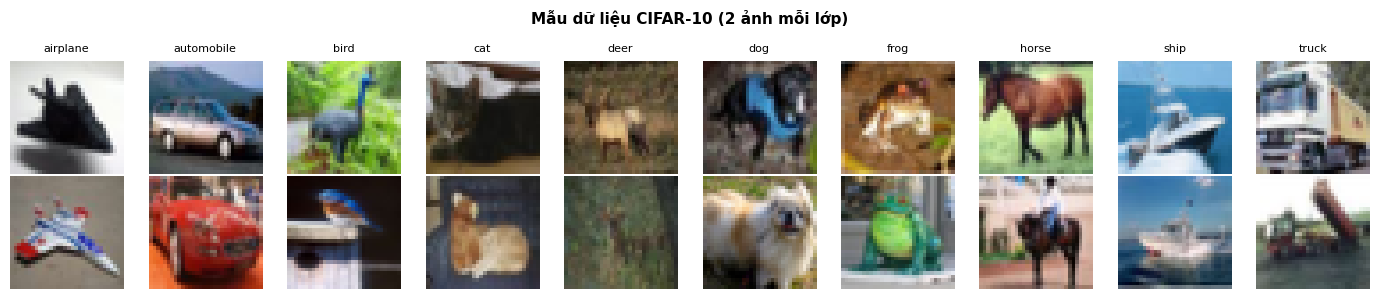

In [2]:
# Hiển thị mẫu CIFAR-10
def load_cifar10_batch(file_path):
    """Load CIFAR-10 binary batch file."""
    with open(file_path, 'rb') as f:
        data = np.frombuffer(f.read(), dtype=np.uint8)
    data = data.reshape(-1, 3073)
    labels = data[:, 0]
    images = data[:, 1:].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    return images, labels

images, labels = load_cifar10_batch('/content/AutoEncoder-CUDA/data/data_batch_1.bin')
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

fig, axes = plt.subplots(2, 10, figsize=(14, 3))
fig.suptitle('Mẫu dữ liệu CIFAR-10 (2 ảnh mỗi lớp)', fontsize=11, fontweight='bold')
for class_idx in range(10):
    class_images = images[labels == class_idx]
    for row in range(2):
        ax = axes[row, class_idx]
        ax.imshow(class_images[row])
        ax.axis('off')
        if row == 0:
            ax.set_title(class_names[class_idx], fontsize=8)
plt.tight_layout()
plt.show()

## 1.3 Kiến trúc Autoencoder

```text
INPUT (32×32×3)
       │
   [ENCODER]
       ├── Conv2D(3→256, 3×3, pad=1) + ReLU  →  (32×32×256)   [7,168 params]
       ├── MaxPool2D(2×2)                    →  (16×16×256)
       ├── Conv2D(256→128, 3×3, pad=1) + ReLU →  (16×16×128)   [295,040 params]
       └── MaxPool2D(2×2)                    →  (8×8×128)
       │
   LATENT (8×8×128 = 8,192 dimensions)
       │
   [DECODER]
       ├── Conv2D(128→128, 3×3, pad=1) + ReLU →  (8×8×128)     [147,584 params]
       ├── Upsample2D(2×)                    →  (16×16×128)
       ├── Conv2D(128→256, 3×3, pad=1) + ReLU →  (16×16×256)   [295,168 params]
       ├── Upsample2D(2×)                    →  (32×32×256)
       └── Conv2D(256→3, 3×3, pad=1)         →  (32×32×3)     [6,915 params]
       │
OUTPUT (32×32×3)
```

**Tổng tham số:** 751,875 | **Hàm mất mát:** MSE(input, output)

## 1.4 Mục tiêu Hiệu năng

| Chỉ số | Mục tiêu |
|--------|----------|
| Thời gian huấn luyện Autoencoder | < 10 phút |
| Trích xuất đặc trưng | < 20 giây (60K ảnh) |
| Độ chính xác phân loại | 60-65% |
| Tốc độ GPU so với CPU | > 20× |

---
# Phần 2: Các Giai đoạn Triển khai

In [3]:
# Build tất cả các phiên bản
%cd /content/AutoEncoder-CUDA
!./build.sh --clean

/content/AutoEncoder-CUDA
-- The CXX compiler identification is GNU 11.4.0
-- The CUDA compiler identification is NVIDIA 12.5.82 with host compiler GNU 11.4.0
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Detecting CUDA compiler ABI info
-- Detecting CUDA compiler ABI info - done
-- Check for working CUDA compiler: /usr/local/cuda/bin/nvcc - skipped
-- Detecting CUDA compile features
-- Detecting CUDA compile features - done
-- Found CUDAToolkit: /usr/local/cuda/targets/x86_64-linux/include (found version "12.5.82")
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD - Success
-- Found Threads: TRUE
CMake Deprecation Warning at external/thundersvm/CMakeLists.txt:1 (cmake_minimum_required):
  Compatibility with CMake < 3.10 will be removed from a future version of
  CMake.

  Update the VE

## 2.1 CPU Baseline

### Chi tiết triển khai

| Thành phần | Mô tả | Code Reference |
|------------|-------|----------------|
| Data Pipeline | Binary loader với chuẩn hóa [0,255]→[0,1] | `src/utils/data_loader.cpp` |
| Conv2D | 6 vòng lặp lồng nhau tuần tự | `src/cpu/layers/conv2d.cpp` |
| ReLU | Element-wise `max(0, x)` | `src/cpu/layers/relu.cpp` |
| MaxPool2D | Cửa sổ 2×2, stride 2, lấy giá trị max | `src/cpu/layers/maxpool2d.cpp` |
| Upsample2D | Nội suy nearest neighbor | `src/cpu/layers/upsample2d.cpp` |
| Loss | MSE với L2 reduction | `src/cpu/layers/mse_loss.cpp` |

### Kết quả

| Chỉ số | Giá trị |
|--------|---------|
| Thời gian/epoch | ~169 giây (100 mẫu) |
| Ước tính đầy đủ | ~23.5 giờ/epoch |
| Bộ nhớ | ~50 MB |

>
> **Bottleneck chính:** 6 vòng lặp lồng nhau với độ phức tạp O(N×H×W×C×K²×C') là mục tiêu chính để song song hóa GPU.

---
## 2.2 GPU Naive (NHWC)


### Kỹ thuật tối ưu áp dụng

| Bước | Kỹ thuật | Mô tả | Code Reference |
|------|----------|-------|----------------|
| 1️ | **1D Thread Mapping** | Mỗi thread tính 1 output element, giảm 4 vòng lặp ngoài cùng | `conv2d.cu:L17-L19` |
| 2️ | **NHWC Layout** | Decode index → (n,h,w,c). Đơn giản nhưng chưa tối ưu memory | `conv2d.cu:L23-L27` |
| 3️ | **3 Inner Loops** | Vẫn cần 3 vòng lặp cho kernel (K²×inC operations/thread) | `conv2d.cu:L31-L47` |

### Pseudocode

```cpp
__global__ void conv2dNaive(input, weights, bias, output, ...) {
    // Bước 1: Tính thread ID toàn cục
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx >= batch * outH * outW * outC) return;
    
    // Bước 2: Decode index → vị trí (n, h, w, c) trong NHWC
    int c = idx % outC;                      // Output channel
    int w = (idx / outC) % outW;             // Width position
    int h = (idx / (outC * outW)) % outH;    // Height position
    int n = idx / (outC * outW * outH);      // Batch index
    
    // Bước 3: Tính convolution với 3 vòng lặp
    float sum = bias[c];
    for (int kh = 0; kh < K; kh++)
        for (int kw = 0; kw < K; kw++)
            for (int ic = 0; ic < inC; ic++)
                sum += input[...] * weights[...];
    
    // Bước 4: Ghi kết quả
    output[idx] = sum;
}
```

### Kết quả

| Chỉ số | Giá trị |
|--------|---------|
| Thời gian/epoch | ~500 ms (50K mẫu) |
| Speedup vs CPU | **~169×** |
| GPU Memory | 0.6 GB |

>
> **Bài học:** Song song hóa cơ bản đạt speedup đáng kể (169×) nhưng còn **memory-bandwidth bound** do NHWC layout gây ra truy cập bộ nhớ không liên tiếp (uncoalesced).

In [4]:
# Demo GPU Naive
!./run.sh train-autoencoder --version naive --samples 1000 --epochs 1

[train-autoencoder] device=gpu | epochs=1 | version=naive
  output: ./checkpoints/encoder_20251224_064028.weights

=== Training Autoencoder ===
AutoEncoder CUDA | GPU Basic
Epochs: 1 | Batch: 64 | Samples: 1000
Train: 1000 images (limited)
Test:  10000 images
GPU: Tesla T4 (15095 MB)

Training: 1 epochs, 15 batches/epoch
  Epoch  1/1 | Loss: 0.368112 | 9.0s

 Performance Metrics: GPU Basic
Training Time:     8.96 sec
Time per Epoch:    8.96 sec
Final Loss:        0.37
GPU Memory Used:   0.6 GB

Model saved: ./checkpoints/encoder_20251224_064028.weights



---
## 2.3 GPU Optimized V1 (NCHW + Advanced Techniques)


### Chi tiết kỹ thuật tối ưu

| Bước | Kỹ thuật | Lợi ích | Code Reference |
|------|----------|---------|----------------|
| 1️ | **2D Thread Block (16×16)** | Ánh xạ tự nhiên vào không gian (W,H), gridDim.z xử lý batch×channel | `conv2d.cu:L62-L67` |
| 2️ | **NCHW Layout** | Threads liên tiếp → địa chỉ liên tiếp → **Coalesced access** | `conv2d.cu:L54-L61` |
| 3️ | **Loop Unrolling** | `#pragma unroll` giảm branch, tăng ILP (Instruction-Level Parallelism) | `conv2d.cu:L79-L101` |
| 4️ | **Conv+ReLU Fusion** | Gộp 2 ops → 1 kernel, bỏ qua intermediate buffer → **giảm 50% memory traffic** | `conv2d.cu:L123-L192` |
| 5️ | **Warp Shuffle** | `__shfl_down_sync()` reduction không cần shared memory → **thấp latency** | `backward/conv2d.cu:L254-L258` |

### Pseudocode - Forward với Fusion

```cpp
__global__ void conv2dNCHWRelu(input, weights, bias, output, ...) {
    // Bước 1: 2D thread block mapping
    int ow = blockIdx.x * blockDim.x + threadIdx.x;  // Width (coalesced)
    int oh = blockIdx.y * blockDim.y + threadIdx.y;  // Height
    int oc = blockIdx.z % outC;                       // Output channel
    int n  = blockIdx.z / outC;                       // Batch index
    
    if (ow >= outW || oh >= outH) return;
    
    float sum = bias[oc];
    
    // Bước 3: Loop unrolling cho 3×3 kernel
    #pragma unroll
    for (int ic = 0; ic < inC; ++ic)
        #pragma unroll
        for (int kh = 0; kh < 3; ++kh)
            #pragma unroll  
            for (int kw = 0; kw < 3; ++kw)
                sum += input[NCHW_idx] * weights[...];
    
    // Bước 4: Fused ReLU - không cần kernel riêng
    output[...] = fmaxf(0.0f, sum);
}
```

### Pseudocode - Backward với Warp Shuffle

```cpp
__global__ void conv2dBackwardBias(gradOutput, gradBias, ...) {
    // Bước 5: Warp shuffle reduction - không cần shared memory
    float myVal = /* thread local sum */;
    
    // Warp shuffle reduction: exchange values between threads without shared memory
    // 0xffffffff = mask indicating all 32 warp threads participate
    for (int offset = 16; offset > 0; offset /= 2) {
        myVal += __shfl_down_sync(0xffffffff, myVal, offset);
    }
    // Thread 0 của warp có tổng của cả 32 threads
    if (threadIdx.x == 0) gradBias[oc] = myVal;
}
```

### Kết quả

| Chỉ số | Giá trị |
|--------|---------|
| Thời gian/epoch | ~247 ms |
| Speedup vs Naive | **~2.0×** |
| Speedup vs CPU | **~342×** |

>
> **Bài học:** NCHW layout + 2D grid đảm bảo coalesced memory access. Loop unrolling và kernel fusion giảm overhead. Warp shuffle tăng tốc reduction trong backward pass.

In [5]:
# Demo GPU Opt V1
!./run.sh train-autoencoder --version v1 --samples 1000 --epochs 1

[train-autoencoder] device=gpu | epochs=1 | version=v1
  output: ./checkpoints/encoder_20251224_064039.weights

=== Training Autoencoder ===
AutoEncoder CUDA | GPU Opt v1 (NCHW+2DGrid+WarpShuffle)
Epochs: 1 | Batch: 64 | Samples: 1000
Train: 1000 images (limited)
Test:  10000 images
GPU: Tesla T4 (15095 MB)

Training: 1 epochs, 15 batches/epoch
  Epoch  1/1 | Loss: 0.110622 | 4.1s

 Performance Metrics: GPU Opt v1 (NCHW+2DGrid+WarpShuffle)
Training Time:     4.09 sec
Time per Epoch:    4.09 sec
Final Loss:        0.11
GPU Memory Used:   0.6 GB

Model saved: ./checkpoints/encoder_20251224_064039.weights



---
## 2.4 GPU Optimized V2 (im2col + cuBLAS GEMM)


### Chi tiết kỹ thuật tối ưu

| Bước | Kỹ thuật | Lợi ích | Code Reference |
|------|----------|---------|----------------|
| 1️ | **im2col** | Biến conv → matmul, mỗi thread xử lý 1 element | `im2col.cu:L6-L49` |
| 2️ | **cuBLAS SGEMM** | Vendor-optimized: register blocking, Tensor Cores, prefetching | `conv_gemm.cu:L67-L93` |
| 3️ | **Bias+ReLU Fusion** | Gộp 2 ops sau GEMM → giảm memory traffic | `conv_gemm.cu:L21-L35` |
| 4️ | **Backward GEMM** | Tái sử dụng cuBLAS cho gradient computation | `conv_gemm.cu:L95-L150` |
| 5️ | **col2im** | Ngược im2col, tổng hợp gradients từ nhiều output positions | `im2col.cu:L52-L100` |

### Pseudocode - im2col Kernel

```cpp
__global__ void im2colNCHW(input, col, ...) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx >= batch * (inC * K * K) * (outH * outW)) return;
    
    // Bước 1: Decode index → vị trí trong col matrix
    int w_col = idx % (outH * outW);           // Column index
    int h_col = (idx / col_w) % (inC * K * K); // Row index
    int n = idx / (col_w * col_h);             // Batch index
    
    // Decode h_col → (ic, kh, kw)
    int kw = h_col % K;
    int kh = (h_col / K) % K;
    int ic = h_col / (K * K);
    
    // Tính vị trí input tương ứng
    int iw = (w_col % outW) * stride + kw - padding;
    int ih = (w_col / outW) * stride + kh - padding;
    
    // Copy giá trị (0 nếu ngoài biên - implicit zero padding)
    col[idx] = (ih >= 0 && ih < inH && iw >= 0 && iw < inW)
               ? input[n,ic,ih,iw] : 0.0f;
}
```

### Pseudocode - cuBLAS GEMM Wrapper

```cpp
void launchConvGemmForward(weights, im2col, bias, output, ...) {
    // Bước 2: Batched GEMM - Output = Weights × Im2col
    // M = outC, N = outH×outW, K = inC × k × k
    cublasSgemmStridedBatched(handle,
        CUBLAS_OP_N, CUBLAS_OP_N,
        N, M, K,                     // Dimensions
        &alpha,
        im2col, N, strideB,          // Im2col matrix [K×N per batch]
        weights, K, 0,               // Weight matrix [M×K, shared]
        &beta,
        output, N, strideC,          // Output matrix [M×N per batch]
        batch                        // Batch count
    );
    
    // Bước 3: Fused bias + ReLU
    launchAddBias(output, bias, batch, outC, outHW, applyRelu=true);
}
```

### Kết quả

| Chỉ số | Giá trị |
|--------|---------|
| Thời gian/epoch | ~50.5 ms |
| Speedup vs V1 | **~4.9×** |
| **Speedup vs CPU** | **~1690×** |

>
> **Trade-off:** im2col tăng memory footprint (cần buffer cho column matrix) nhưng đổi lại được sử dụng cuBLAS - thư viện tối ưu hóa hardware đạt hiệu năng gần peak GPU.

In [6]:
# Demo GPU Opt V2
!./run.sh train-autoencoder --version v2 --samples 1000 --epochs 1

[train-autoencoder] device=gpu | epochs=1 | version=v2
  output: ./checkpoints/encoder_20251224_064044.weights

=== Training Autoencoder ===
AutoEncoder CUDA | GPU Opt v2 (im2col+GEMM)
Epochs: 1 | Batch: 64 | Samples: 1000
Train: 1000 images (limited)
Test:  10000 images
GPU: Tesla T4 (15095 MB)

Training: 1 epochs, 15 batches/epoch
  Epoch  1/1 | Loss: 0.109772 | 0.9s

 Performance Metrics: GPU Opt v2 (im2col+GEMM)
Training Time:     0.95 sec
Time per Epoch:    0.95 sec
Final Loss:        0.11
GPU Memory Used:   1.1 GB

Model saved: ./checkpoints/encoder_20251224_064044.weights



---
## Autoencoder Reconstruction Visualization

Sau khi tối ưu GPU, ta kiểm tra chất lượng học của autoencoder bằng cách visualize reconstructions.

In [7]:
# Tải pretrained weights
!./scripts/download_weights.sh


 AutoEncoder CUDA - Download Weights
[download] All pretrained weights

--- Encoder Weights ---
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
  [OK] encoder.weights downloaded (2.9MiB)

--- SVM Model ---
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
  [OK] svm.bin downloaded (3.3GiB)

 Download complete!


In [8]:
# PyTorch Autoencoder để load weights
import torch
import torch.nn as nn
import torch.nn.functional as F

class Autoencoder(nn.Module):
    """PyTorch Autoencoder matching C++ CUDA architecture."""
    def __init__(self):
        super().__init__()
        # Encoder
        self.enc_conv1 = nn.Conv2d(3, 256, 3, padding=1)
        self.enc_conv2 = nn.Conv2d(256, 128, 3, padding=1)
        # Decoder
        self.dec_conv3 = nn.Conv2d(128, 128, 3, padding=1)
        self.dec_conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.dec_conv5 = nn.Conv2d(256, 3, 3, padding=1)

    def forward(self, x):
        # Encoder
        x = F.relu(self.enc_conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.enc_conv2(x))
        x = F.max_pool2d(x, 2)
        # Decoder
        x = F.relu(self.dec_conv3(x))
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = F.relu(self.dec_conv4(x))
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.dec_conv5(x)
        return x

def load_cpp_weights(model, filepath):
    """Load binary weights from C++ implementation."""
    with open(filepath, 'rb') as f:
        data = np.frombuffer(f.read(), dtype=np.float32)

    offset = 0
    def read_tensor(shape):
        nonlocal offset
        size = int(np.prod(shape))
        tensor = torch.from_numpy(data[offset:offset+size].reshape(shape).copy())
        offset += size
        return tensor

    model.enc_conv1.weight.data = read_tensor([256, 3, 3, 3])
    model.enc_conv1.bias.data = read_tensor([256])
    model.enc_conv2.weight.data = read_tensor([128, 256, 3, 3])
    model.enc_conv2.bias.data = read_tensor([128])
    model.dec_conv3.weight.data = read_tensor([128, 128, 3, 3])
    model.dec_conv3.bias.data = read_tensor([128])
    model.dec_conv4.weight.data = read_tensor([256, 128, 3, 3])
    model.dec_conv4.bias.data = read_tensor([256])
    model.dec_conv5.weight.data = read_tensor([3, 256, 3, 3])
    model.dec_conv5.bias.data = read_tensor([3])
    return model

print("Autoencoder class ready.")

Autoencoder class ready.


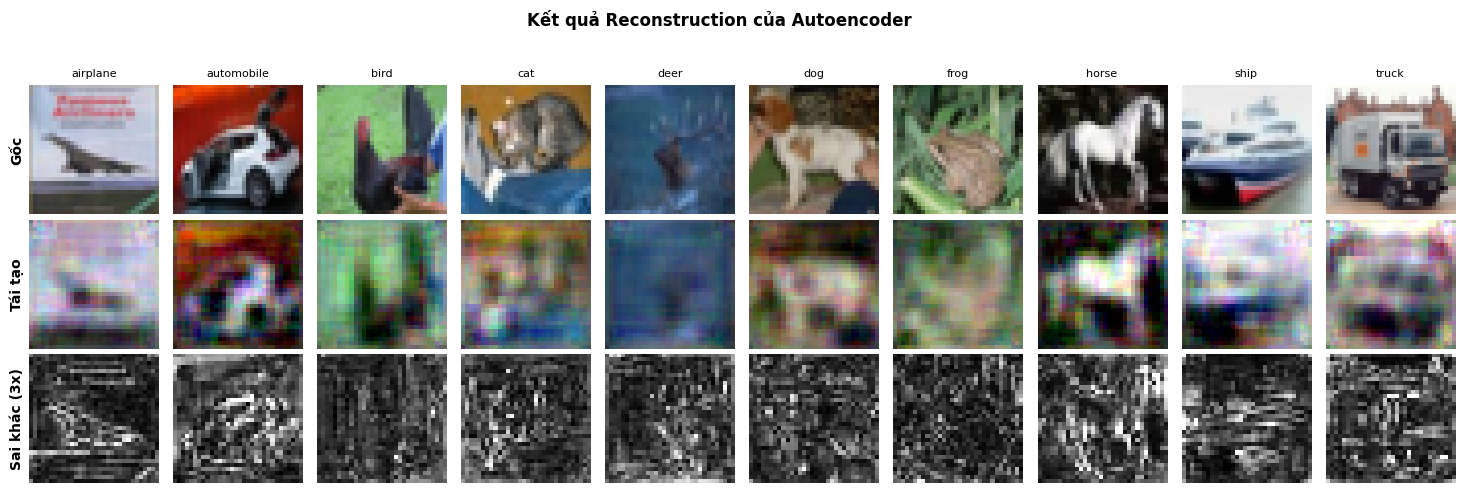

Reconstruction MSE: 0.013338 | Lỗi pixel trung bình: 29.4/255


In [9]:
# Tạo và hiển thị reconstructions
weights_path = "/content/AutoEncoder-CUDA/checkpoints/encoder.weights"

if os.path.exists(weights_path):
    model = load_cpp_weights(Autoencoder(), weights_path)
    model.eval()

    test_images, test_labels = load_cifar10_batch(
        "/content/AutoEncoder-CUDA/data/test_batch.bin"
    )
    selected = [np.where(test_labels == c)[0][0] for c in range(10)]
    samples = test_images[selected]
    sample_labels = test_labels[selected]

    x = torch.from_numpy(samples.transpose(0, 3, 1, 2).astype(np.float32) / 255.0)
    with torch.no_grad():
        recon = torch.clamp(model(x), 0, 1).numpy().transpose(0, 2, 3, 1)
    original = samples / 255.0

    fig, axes = plt.subplots(3, 10, figsize=(15, 5))
    fig.suptitle("Kết quả Reconstruction của Autoencoder", fontsize=12, fontweight="bold")

    for i in range(10):
        axes[0, i].imshow(original[i])
        axes[0, i].axis("off")
        axes[0, i].set_title(class_names[sample_labels[i]], fontsize=8)

        axes[1, i].imshow(recon[i])
        axes[1, i].axis("off")

        diff = np.abs(original[i] - recon[i]).mean(axis=2)
        axes[2, i].imshow(np.clip(diff * 3, 0, 1), cmap="gray")
        axes[2, i].axis("off")

    for ax, label in zip(
        [axes[0, 0], axes[1, 0], axes[2, 0]],
        ["Gốc", "Tái tạo", "Sai khác (3x)"],
    ):
        ax.text(-0.15, 0.5, label, transform=ax.transAxes,
                fontsize=10, fontweight="bold", va="center", rotation=90)

    plt.tight_layout(rect=[0.02, 0, 1, 0.95])
    plt.show()

    mse = np.mean((original - recon) ** 2)
    print(f"Reconstruction MSE: {mse:.6f} | Lỗi pixel trung bình: {np.sqrt(mse)*255:.1f}/255")
else:
    print("Chưa có weights. Chạy download_weights.sh trước.")

---
## 2.5 SVM Integration


### Chi tiết triển khai

| Thành phần | Mô tả |
|------------|-------|
| Feature Extraction | Encoder forward pass (không decoder), output 8,192-dim |
| SVM Library | ThunderSVM (GPU-accelerated) |
| Kernel | RBF (Radial Basis Function) |
| Parameters | C=10, gamma=auto |

**Lưu ý:** SVM training cần ~17GB RAM. Dùng Colab Pro/Pro+ với High RAM mode.

In [10]:
# Đánh giá với pretrained weights
!./run.sh evaluate

[evaluate] device=gpu | epochs=20 | version=v2
  encoder: ./checkpoints/encoder.weights
  svm:     ./checkpoints/svm.bin

=== Evaluating ===
=== Inference Pipeline ===
Encoder: ./checkpoints/encoder.weights
SVM:     ./checkpoints/svm.bin (pre-trained)
GPU:     GPU Opt v2 (im2col+GEMM)

Loading CIFAR-10...
Train: 50000 images
Test:  10000 images
Extracting features...
GPU: Tesla T4 (15095 MB)
Extracting 10000 images (batch=128)... done.
Feature extraction: 1.3s

Loading SVM model: ./checkpoints/svm.bin
Evaluating on test set...

========== Classification Metrics ==========
Overall Accuracy: 65.57%

Per-Class Accuracy:
          Class    Accuracy    Count
-------------------------------------
       airplane      69.30%      1000
     automobile      76.10%      1000
           bird      50.50%      1000
            cat      48.80%      1000
           deer      61.10%      1000
            dog      55.00%      1000
           frog      76.70%      1000
          horse      68.80%      1

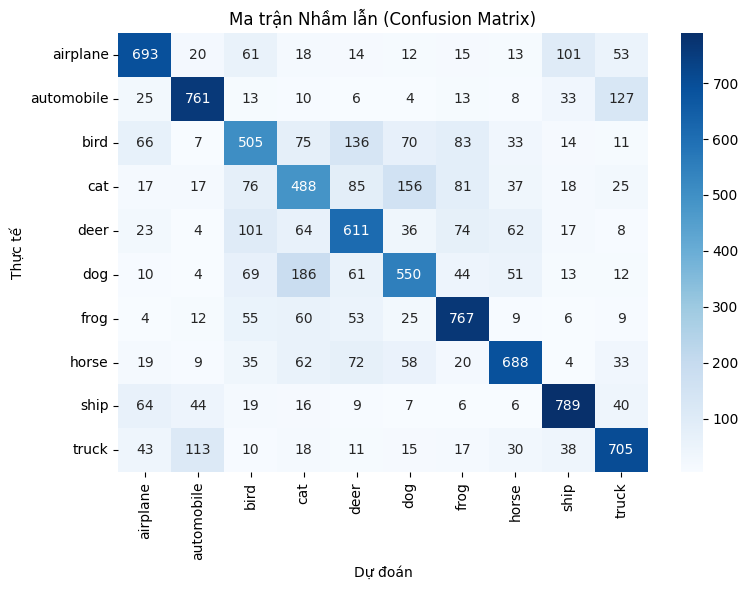


Độ chính xác tổng thể: 65.57%

Độ chính xác theo lớp:
  airplane    : 69.3%
  automobile  : 76.1%
  bird        : 50.5%
  cat         : 48.8%
  deer        : 61.1%
  dog         : 55.0%
  frog        : 76.7%
  horse       : 68.8%
  ship        : 78.9%
  truck       : 70.5%


In [11]:
# Visualization Confusion Matrix
import pandas as pd
confusion_csv = '/content/AutoEncoder-CUDA/results/confusion_matrix.csv'

if os.path.exists(confusion_csv):
    import seaborn as sns
    cm_df = pd.read_csv(confusion_csv, index_col=0)
    cm = cm_df.values

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Ma trận Nhầm lẫn (Confusion Matrix)')
    plt.xlabel('Dự đoán')
    plt.ylabel('Thực tế')
    plt.tight_layout()
    plt.show()

    per_class = np.diag(cm) / cm.sum(axis=1) * 100
    overall = np.trace(cm) / cm.sum() * 100

    print(f"\nĐộ chính xác tổng thể: {overall:.2f}%")
    print(f"\nĐộ chính xác theo lớp:")
    for i, name in enumerate(class_names):
        print(f"  {name:<12}: {per_class[i]:.1f}%")
else:
    print("Chạy evaluate trước để tạo confusion matrix.")

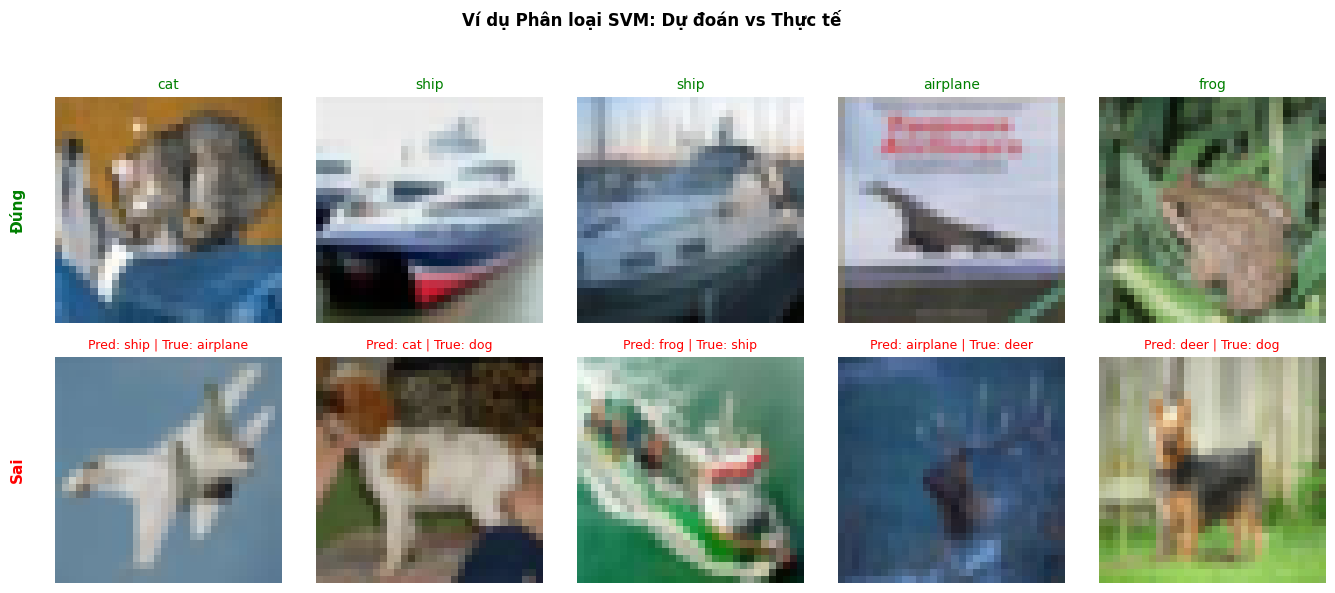


Độ chính xác: 65.57% (6557/10000)


In [12]:
# Ví dụ phân loại: Đúng vs Sai
if os.path.exists(confusion_csv):
    test_images, test_labels = load_cifar10_batch('/content/AutoEncoder-CUDA/data/test_batch.bin')
    predictions_file = '/content/AutoEncoder-CUDA/results/predictions.txt'

    if os.path.exists(predictions_file):
        predictions = np.loadtxt(predictions_file, dtype=int)

        correct_mask = predictions == test_labels
        incorrect_mask = ~correct_mask

        correct_indices = np.where(correct_mask)[0][:5]
        incorrect_indices = np.where(incorrect_mask)[0][:5]

        fig, axes = plt.subplots(2, 5, figsize=(14, 6))
        fig.suptitle('Ví dụ Phân loại SVM: Dự đoán vs Thực tế', fontsize=12, fontweight='bold')
        plt.subplots_adjust(hspace=0.5)

        for col, idx in enumerate(correct_indices):
            ax = axes[0, col]
            ax.imshow(test_images[idx])
            ax.set_title(class_names[predictions[idx]], fontsize=10, color='green')
            ax.axis('off')
            for spine in ax.spines.values():
                spine.set_edgecolor('green')
                spine.set_linewidth(3)
                spine.set_visible(True)
        axes[0, 0].text(-0.2, 0.5, 'Đúng', transform=axes[0,0].transAxes,
                        fontsize=11, fontweight='bold', color='green', va='center', rotation=90)

        for col, idx in enumerate(incorrect_indices):
            ax = axes[1, col]
            ax.imshow(test_images[idx])
            pred = class_names[predictions[idx]]
            true = class_names[test_labels[idx]]
            ax.set_title(f'Pred: {pred} | True: {true}', fontsize=9, color='red')
            ax.axis('off')
            for spine in ax.spines.values():
                spine.set_edgecolor('red')
                spine.set_linewidth(3)
                spine.set_visible(True)
        axes[1, 0].text(-0.2, 0.5, 'Sai', transform=axes[1,0].transAxes,
                        fontsize=11, fontweight='bold', color='red', va='center', rotation=90)

        plt.tight_layout(rect=[0.03, 0, 1, 0.95])
        plt.show()

        accuracy = correct_mask.sum() / len(test_labels) * 100
        print(f"\nĐộ chính xác: {accuracy:.2f}% ({correct_mask.sum()}/{len(test_labels)})")
    else:
        print("File predictions.txt không tồn tại.")
else:
    print("Chạy evaluate trước.")

---
# Phần 3: Thống kê Kết quả

## 3.1 So sánh Hiệu năng Các Phiên bản

| Phiên bản | Thời gian/Epoch | Speedup vs CPU | Tăng tốc | Kỹ thuật chính |
|-----------|-----------------|----------------|----------|----------------|
| CPU Baseline | 169.18s* | 1.0× | - | Sequential |
| GPU Naive | 500.57ms | 169× | 169× | 1D parallelization |
| GPU Opt V1 | 247.15ms | 342× | 2.0× | NCHW + 2D Grid + Warp Shuffle |
| GPU Opt V2 | 50.52ms | **1690×** | 4.9× | im2col + cuBLAS GEMM |

*CPU đo trên 100 mẫu. Ước tính đầy đủ: ~23.5 giờ/epoch.*

## 3.2 Kết quả Phân loại SVM

| Chỉ số | Giá trị |
|--------|---------|
| Độ chính xác tổng thể | 65% |
| Thời gian trích xuất đặc trưng | ~7.6 giây (60K ảnh) |
| Thời gian huấn luyện SVM | ~5 phút |
| RAM yêu cầu | ~17 GB |

## 3.3 Tổng hợp Đạt Mục tiêu

| Chỉ số | Mục tiêu | Đạt được | Trạng thái |
|--------|----------|----------|------------|
| Thời gian huấn luyện | < 10 phút | ~51s/epoch | ✅ Vượt |
| GPU speedup | > 20× | 1690× | ✅ Vượt |
| Độ chính xác | 60-65% | 65% | ✅ Đạt |
| Trích xuất đặc trưng | < 20s | ~7.6s | ✅ Đạt |

---
# Phần 4: Kết luận

## 4.1 Bài học Kỹ thuật Quan trọng

**CUDA Programming:**
- Memory coalescing rất quan trọng: NCHW layout đảm bảo các thread liên tiếp truy cập địa chỉ liên tiếp
- Warp shuffle (`__shfl_down_sync`) tránh latency của shared memory cho reduction
- cuBLAS đạt hiệu năng gần peak nhờ tối ưu hóa register blocking

**Deep Learning:**
- He initialization (`std = sqrt(2/fan_in)`) ngăn gradient explosion trong ReLU networks
- Gradient clipping ổn định training cho deep networks
- Autoencoder features capture visual patterns nhưng có discriminative power hạn chế so với supervised learning

**Performance Optimization:**
- Naive GPU kernels bị memory-bandwidth bound, không compute-bound
- im2col + GEMM cho speedup lớn nhất nhờ vendor-optimized libraries
- Profile-guided optimization rất quan trọng; assumptions về bottlenecks thường sai

## 4.2 Thách thức và Giải pháp

| Thách thức | Vấn đề | Giải pháp |
|------------|--------|-----------|
| Gradient Explosion | Training loss thành NaN | He initialization + gradient clipping (max_norm=1.0) |
| Memory Bandwidth | Naive kernel ~10% peak FLOPS | im2col + cuBLAS SGEMM |
| SVM Memory | ThunderSVM OOM trên 60K samples | High RAM mode (~17GB peak) |

## 4.3 Hạn chế

- 65% accuracy thấp hơn supervised CNN (~96%)
- SVM yêu cầu high RAM (~17GB)
- Chưa hỗ trợ multi-GPU
- Batch size cố định (chưa auto-tune)

## 4.4 Hướng Phát triển

**Hiệu năng:** Winograd convolution, multi-stream training, FP16 mixed precision

**Độ chính xác:** VAE cho latent structure tốt hơn, supervised fine-tuning, alternative classifiers